# Description

Runs hierarchical clustering on the z_score_std version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

10

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=10
env: OPEN_BLAS_NUM_THREADS=10
env: NUMEXPR_NUM_THREADS=10
env: OMP_NUM_THREADS=10


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
np.random.seed(0)

In [6]:
NULL_DIR = conf.RESULTS["CLUSTERING_NULL_DIR"] / "shuffle_lvs"

## Input data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    NULL_DIR,
    "data_transformations",
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/opt/data/results/clustering/null_sims/shuffle_lvs/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

## Clustering

In [10]:
from sklearn.cluster import AgglomerativeClustering

In [11]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [12]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 75  # sqrt(3749) + some more to get closer to 295
CLUSTERING_OPTIONS["LINKAGE"] = {"ward", "complete", "average", "single"}
CLUSTERING_OPTIONS["AFFINITY"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_MIN': 2,
 'K_MAX': 75,
 'LINKAGE': {'average', 'complete', 'single', 'ward'},
 'AFFINITY': 'euclidean'}

In [13]:
CLUSTERERS = {}

idx = 0

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for linkage in CLUSTERING_OPTIONS["LINKAGE"]:
        if linkage == "ward":
            affinity = "euclidean"
        else:
            affinity = "precomputed"

        clus = AgglomerativeClustering(
            n_clusters=k,
            affinity=affinity,
            linkage=linkage,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [14]:
display(len(CLUSTERERS))

296

In [15]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('AgglomerativeClustering #0',
 AgglomerativeClustering(affinity='precomputed', linkage='complete'))

('AgglomerativeClustering #1',
 AgglomerativeClustering(affinity='precomputed', linkage='single'))

In [16]:
clustering_method_name = method_name
display(clustering_method_name)

'AgglomerativeClustering'

## Output directory

In [17]:
# output dir for this notebook
RESULTS_DIR = Path(
    NULL_DIR,
    "runs",
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/opt/data/results/clustering/null_sims/shuffle_lvs/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [18]:
data = pd.read_pickle(input_filepath)

In [19]:
data.shape

(3752, 987)

In [20]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-2.408007,-1.745911,1.383013,0.158718,-0.240933,-0.304911,1.823117,-0.716278,-1.769346,-0.043794,...,0.399227,0.849885,-0.593292,0.636568,0.409726,-0.871713,1.638770,0.285165,0.585307,0.592347
100002_raw-Energy,-0.508508,0.514427,-0.792865,-0.091775,-0.013409,0.194047,1.353713,0.117286,-0.323516,-1.641116,...,-0.038535,-1.139394,-0.951591,1.197872,0.893819,-0.820655,0.928634,-0.716778,-0.085735,-1.208965
100003_raw-Protein,-0.284597,-0.325076,-1.412980,1.255510,0.343603,-2.471878,-0.149640,-0.715178,-0.548948,1.210352,...,1.006094,0.595064,1.774559,-0.335165,0.394177,-0.188345,-1.864716,-0.124875,1.253625,0.804944
100004_raw-Fat,-0.427503,-0.096524,-0.348654,-1.250087,-0.253145,-0.236606,-0.600627,0.277239,-0.844748,-0.998437,...,0.249993,-1.520660,0.037241,0.514992,0.512538,-1.083619,0.310643,-1.719033,-0.970770,-2.628077
100005_raw-Carbohydrate,-1.502621,-1.083034,0.531159,0.332981,-1.240640,-0.852565,-0.003171,0.561912,-0.772413,-0.372739,...,-0.577730,-1.163380,0.000251,-0.345607,-1.610004,0.194078,0.605594,1.182825,-1.567705,-0.011902


In [21]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [22]:
from sklearn.metrics import pairwise_distances
from clustering.ensembles.utils import generate_ensemble

In [23]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["AFFINITY"])

In [24]:
data_dist.shape

(3752, 3752)

In [25]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14077504.0
mean     44.282964827108536
std      3.6081888872223002
min                     0.0
25%      43.065701593577415
50%       43.99565511661875
75%      44.953600800379995
max       91.89243711532622
dtype: object

In [26]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
    affinity_matrix=data_dist,
)

100%|██████████| 296/296 [16:44<00:00,  3.39s/it]


In [27]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(296, 3)

In [28]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
AgglomerativeClustering #0,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
AgglomerativeClustering #1,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
AgglomerativeClustering #2,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
AgglomerativeClustering #3,"{'affinity': 'euclidean', 'compute_full_tree':...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
AgglomerativeClustering #4,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3


In [29]:
ensemble["n_clusters"].value_counts().head()

75    4
20    4
22    4
23    4
24    4
Name: n_clusters, dtype: int64

In [30]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    296.000000
mean      38.500000
std       21.396182
min        2.000000
25%       20.000000
50%       38.500000
75%       57.000000
max       75.000000
Name: n_clusters, dtype: float64

## Testing

In [31]:
assert ensemble_stats["min"] > 1

In [32]:
assert not ensemble["n_clusters"].isna().any()

In [33]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [34]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [35]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Add clustering quality measures

In [36]:
from sklearn.metrics import calinski_harabasz_score

In [37]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [38]:
ensemble.shape

(296, 4)

In [39]:
ensemble.head()

,clusterer_params,partition,n_clusters,ch_score
clusterer_id,,,,
AgglomerativeClustering #0,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,4.526108
AgglomerativeClustering #1,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,4.526108
AgglomerativeClustering #2,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,4.526108
AgglomerativeClustering #3,"{'affinity': 'euclidean', 'compute_full_tree':...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.903606
AgglomerativeClustering #4,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,4.385023


## Save

In [40]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        {k: v for k, v in CLUSTERING_OPTIONS.items() if k != "LINKAGE"},
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/shuffle_lvs/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/AgglomerativeClustering-AFFINITY_euclidean-K_MAX_75-K_MIN_2.pkl')

In [41]:
ensemble.to_pickle(output_filename)

# Cluster quality

In [42]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,ch_score
n_clusters,
2,3.870482
3,3.601644
4,3.588018
5,3.499925
6,3.377480
7,3.390275
8,3.274477
9,3.193639
10,3.149039


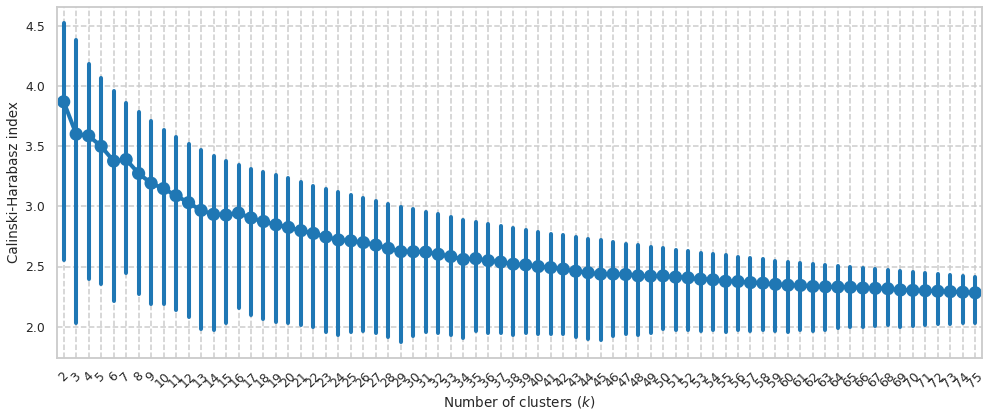

In [43]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [44]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [45]:
parts.head()

n_clusters
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dtype: object

In [46]:
assert np.all(
    [
        parts.loc[k].shape == (len(CLUSTERING_OPTIONS["LINKAGE"]), data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [47]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [48]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [49]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

5     0.510360
4     0.507821
2     0.505535
3     0.505015
7     0.502361
6     0.501940
16    0.491550
59    0.479578
28    0.478730
70    0.478629
25    0.476387
69    0.476084
61    0.475345
58    0.473561
68    0.473506
Name: k, dtype: float64

In [50]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [51]:
parts_ari_df.shape

(74, 6)

In [52]:
assert (
    int(
        (len(CLUSTERING_OPTIONS["LINKAGE"]) * (len(CLUSTERING_OPTIONS["LINKAGE"]) - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [53]:
parts_ari_df.head()

,0,1,2,3,4,5
2,1.0,1.0,0.011070,1.0,0.011070,0.011070
3,1.0,1.0,0.010030,1.0,0.010030,0.010030
4,1.0,1.0,0.015642,1.0,0.015642,0.015642
5,1.0,1.0,0.020719,1.0,0.020719,0.020719
6,1.0,1.0,0.003880,1.0,0.003880,0.003880


## Save

In [54]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/shuffle_lvs/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/AgglomerativeClustering-stability-AFFINITY_euclidean-K_MAX_75-K_MIN_2-LINKAGE_complete_single_average_ward.pkl')

In [55]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [56]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [57]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [58]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,1.00000
1,2,1,1.00000
2,2,2,0.01107
3,2,3,1.00000
4,2,4,0.01107


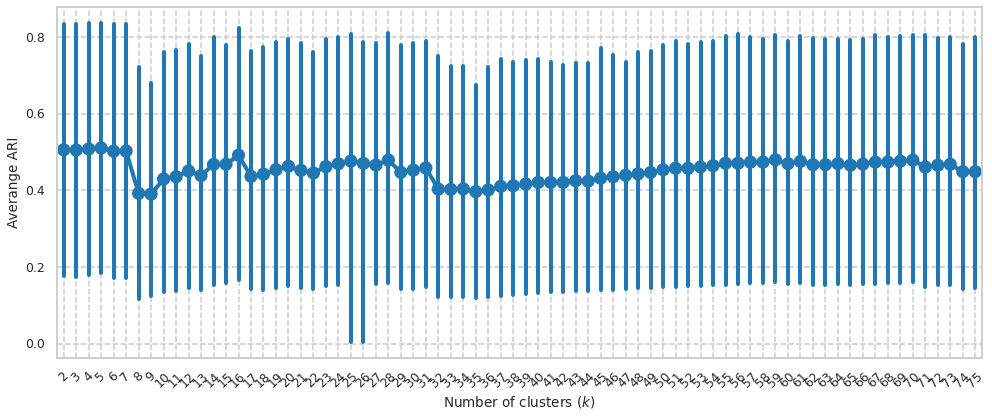

In [59]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()